# IMPORTANCE!
1. I assigned wrong x-axis labels to all figures. However, due to the submission restriction by kaggle, I do not have a second chance to run the notebook again. I changed the code so that it will display correctly next time. But I have to leave unchanged codes here
2. You may notice some inconsistencies in cell number. This is because of the bug in [kaggle-api](https://github.com/Kaggle/kaggle-api). It sometimes return NULL. So I have to run the same cell again in order to get the correct test score
3. I set all random_state to 0 or 117, all are my favoriate numbers. So when I pick the random seed, I may select randomly from my favoriate numbers (which are 0, 2, 117). This can be set to random number. Difference in my code does not affect the result. (Just for clarification of the issue of reproducibility)

In [1]:
import numpy as np
import pandas as pd
from plot_helper import gridsearch_vis
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

### Data Preprocessing

In [2]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
train.Age = train.Age.fillna(int(np.mean(train.Age)))
train.Fare = train.Fare.fillna(np.mean(train.Fare))
train.Embarked = train.Embarked.fillna(3).replace(['S', 'C', 'Q'], [0,1,2])
train.Sex = train.Sex.replace(['male', 'female'], [0, 1])
train = train[train.columns.tolist()[1:] + [train.columns.tolist()[0]]]
test = test.drop(['PassengerId', 'Name', 'Ticket','Cabin'], axis=1)
test.Age = test.Age.fillna(int(np.mean(test.Age)))
test.Fare = test.Fare.fillna(np.mean(test.Fare))
test.Embarked = test.Embarked.fillna(3).replace(['S', 'C', 'Q'], [0,1,2])
test.Sex = test.Sex.replace(['male', 'female'], [0, 1])

In [3]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,22.0,1,0,7.2500,0,0
1,1,1,38.0,1,0,71.2833,1,1
2,3,1,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,1
4,3,0,35.0,0,0,8.0500,0,0


In [4]:
train_data = train.values[:,:-1]
train_label = train.values[:,-1].astype('?')
test_data = test.values

### Decision Tree

In [5]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
params = {'criterion':('gini', 'entropy'), 'min_samples_leaf':range(1,11)}
dtree = DecisionTreeClassifier(criterion='gini',random_state=117,min_samples_leaf=5)
clf = GridSearchCV(dtree, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
print(clf.best_estimator_.feature_importances_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_decision_tree.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_decision_tree.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params {'criterion': 'gini', 'min_samples_leaf': 6}
Best training score: 0.9779275212667644
Best Cross Valiadtion score: 0.8271604938271605
[0.15528932 0.4573614  0.12647383 0.04247546 0.00668075 0.20027796
 0.01144129]


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.77511


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

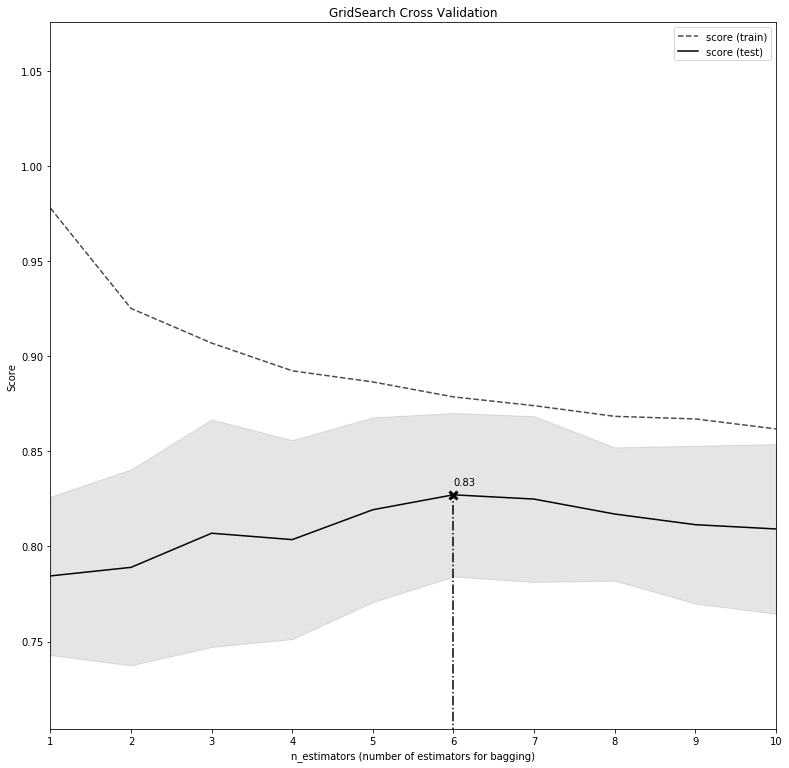

In [6]:
gridsearch_vis(clf, x_label='min_samples_leaf', x_range=params['min_samples_leaf'])

In [7]:
from sklearn.externals.six import StringIO
import pydotplus
dot_data = StringIO()
dtree = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],random_state=0,min_samples_leaf=clf.best_params_['min_samples_leaf'])
dtree.fit(train_data, train_label)
export_graphviz(dtree, 
                    out_file=dot_data,
                    filled=True,
                    rounded=True,
                    impurity=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("decision_tree_visualization.pdf")

True

### Random Forest

In [8]:
# My MAC cannot finish computing this cell. Run it on other machine and the best parameter settings are as follows
from sklearn.ensemble import RandomForestClassifier
# params = {'n_estimators': range(10,1001, 10), 'criterion': ('gini', 'entropy'), 'min_samples_split': range(2,11)}
# rf = RandomForestClassifier(random_state=0, n_jobs=16, verbose=1)
# clf = GridSearchCV(rf, params, cv=10, n_jobs=-1)
# clf.fit(train_data, train_label)
# print('Best params', clf.best_params_)
# print('Best training score:', max(clf.cv_results_['mean_train_score']))
# print('Best Cross Valiadtion score:', clf.best_score_)
print({'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 130})
print(0.8338945005611672)

{'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 130}
0.8338945005611672


In [9]:
rf = RandomForestClassifier(random_state=117, n_jobs=-1, criterion='gini', min_samples_split=10, n_estimators=130)
rf.fit(train_data, train_label)
test_label = rf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_random_forest.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_random_forest.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.75119


### SVM

In [10]:
# Sorry, I can't finish running this cell.
# I run it on a 40vCPU instance: Intel(R) Xeon(R) CPU E5-2650 v3 @ 2.30GHz
# for 5 hours when my SSH session times out...
# I also run it on my own MAC: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
# for 12 hours !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# I love my MAC so much. I am afraid that if I keep it running for longer time,
# the CPU would burn... Thus, I decide to leave it here unsolved...
from sklearn.svm import SVC
# params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(2,5), 'decision_function_shape': ['ovo', 'ovr']}
# svm = SVC()
# clf = GridSearchCV(svm, params, cv=10, n_jobs=16)
# clf.fit(train_data, train_label) 
# print(clf.best_params_)
# print(clf.best_score_)

In [12]:
# try another gridSearch
params = {'kernel': ['rbf'], 'gamma': [ 0.001, 0.01, 0.1, 1], 'C': [1, 10, 50, 100,200,300, 1000]}
svm = SVC(random_state=117)
clf = GridSearchCV(svm, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label) 
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_svm.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_svm.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.2s


Best params {'C': 200, 'gamma': 0.001, 'kernel': 'rbf'}
Best training score: 0.9735632738868839
Best Cross Valiadtion score: 0.8069584736251403


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    5.1s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.77511


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

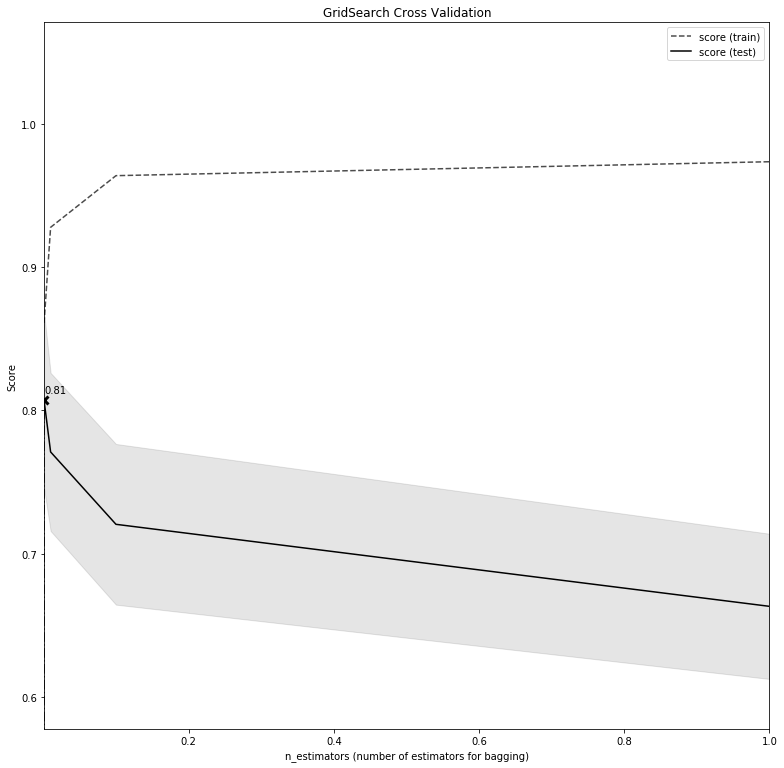

In [13]:
gridsearch_vis(clf, x_label='gamma', x_range=params['gamma'])

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

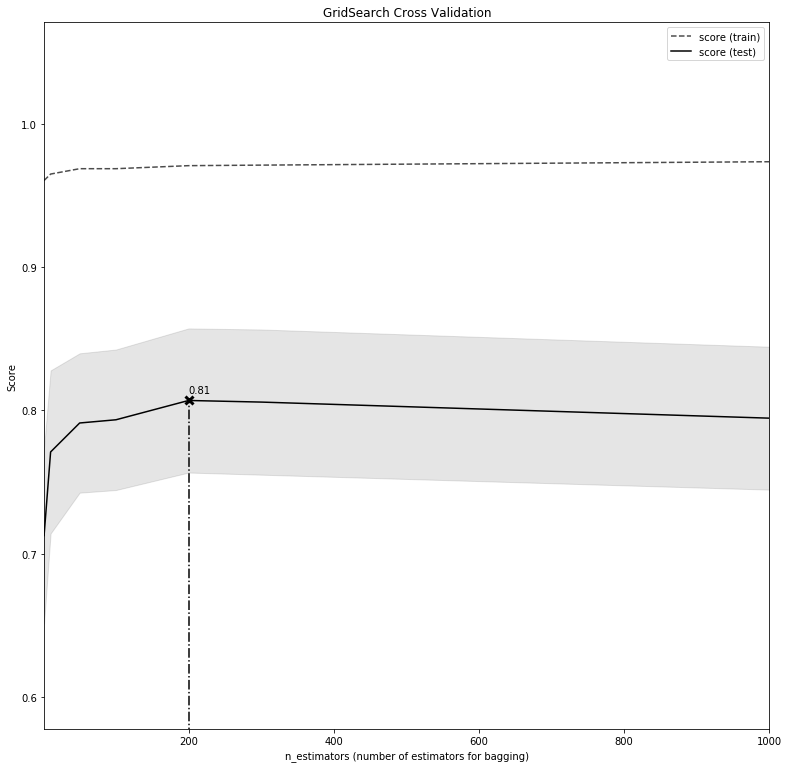

In [14]:
gridsearch_vis(clf, x_label='C', x_range=params['C'])

### LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
lda = LDA()
print('cross validation score:', np.mean(cross_val_score(lda, train_data, train_label, cv=10)))
lda.fit(train_data, train_label)
test_label = lda.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_lda.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_lda.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

cross validation score: 0.790094200431279
Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.76076


### QDA

In [17]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()
print('cross validation score:', np.mean(cross_val_score(qda, train_data, train_label, cv=10)))
qda.fit(train_data, train_label)
test_label = qda.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_qda.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_qda.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

cross validation score: 0.8035784814436499
Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.76076


### Gaussian Naive Bayes

In [18]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
print('cross validation score:', np.mean(cross_val_score(gnb, train_data, train_label, cv=10)))
gnb.fit(train_data, train_label)
test_label = gnb.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_GaussianNB.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_GaussianNB.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

cross validation score: 0.7868238565429577
Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.75119


### Multinomial Naive Bayes

In [19]:
from sklearn.naive_bayes import MultinomialNB
mnb = GaussianNB()
mnb.fit(train_data, train_label)
print('cross validation score:', np.mean(cross_val_score(mnb, train_data, train_label, cv=10)))
test_label = mnb.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_MultinomialNB.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_MultinomialNB.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

cross validation score: 0.7868238565429577
Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.75119


### Multilayer Perceptron

In [20]:
from sklearn.neural_network import MLPClassifier
params={'hidden_layer_sizes': range(2, 11), 'activation': ['logistic', 'tanh', 'relu']}
mlp = MLPClassifier(random_state=117)
clf = GridSearchCV(mlp, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_MLP.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_MLP.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 27 candidates, totalling 270 fits


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr

Best params {'activation': 'relu', 'hidden_layer_sizes': 9}
Best training score: 0.7747875107032816
Best Cross Valiadtion score: 0.7598204264870931


/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.75598


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

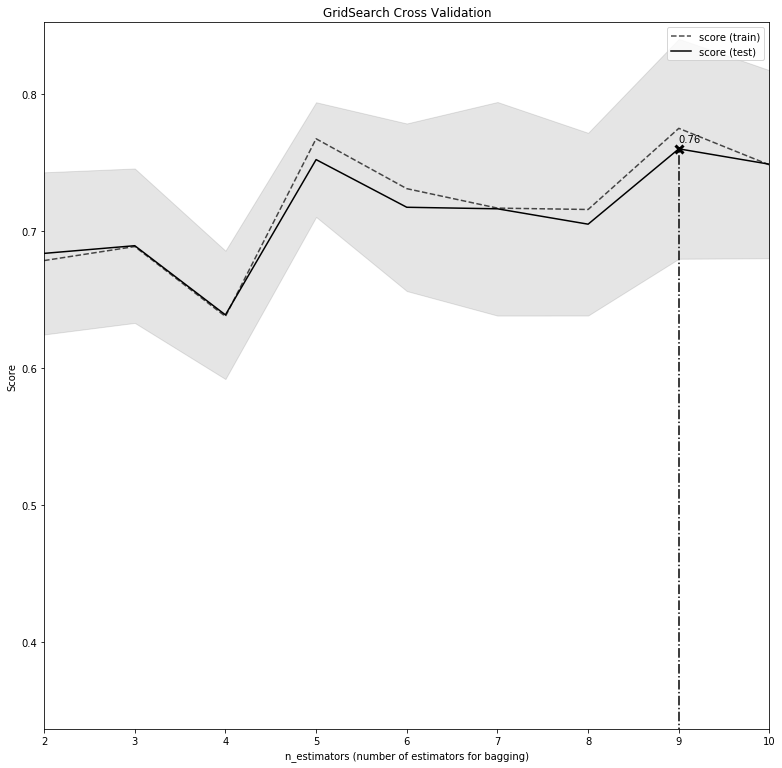

In [21]:
gridsearch_vis(clf, x_label='hidden_layer_sizes', x_range=params['hidden_layer_sizes'])

### Bagging for Decision Tree

In [22]:
from sklearn.ensemble import BaggingClassifier
params = {"base_estimator__criterion" : ["gini", "entropy"],
          "base_estimator__splitter" :   ["best", "random"],
          "n_estimators" : range(1,11,2),
          "bootstrap_features":  [True, False]}
dtree = DecisionTreeClassifier(random_state=117)
bagging_dtree = BaggingClassifier(dtree, random_state=117)
clf = GridSearchCV(bagging_dtree, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_Bagging_Dtree.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_Bagging_Dtree.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best params {'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'best', 'bootstrap_features': True, 'n_estimators': 9}
Best training score: 0.9628385217198699
Best Cross Valiadtion score: 0.8237934904601572


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.0s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.73684


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

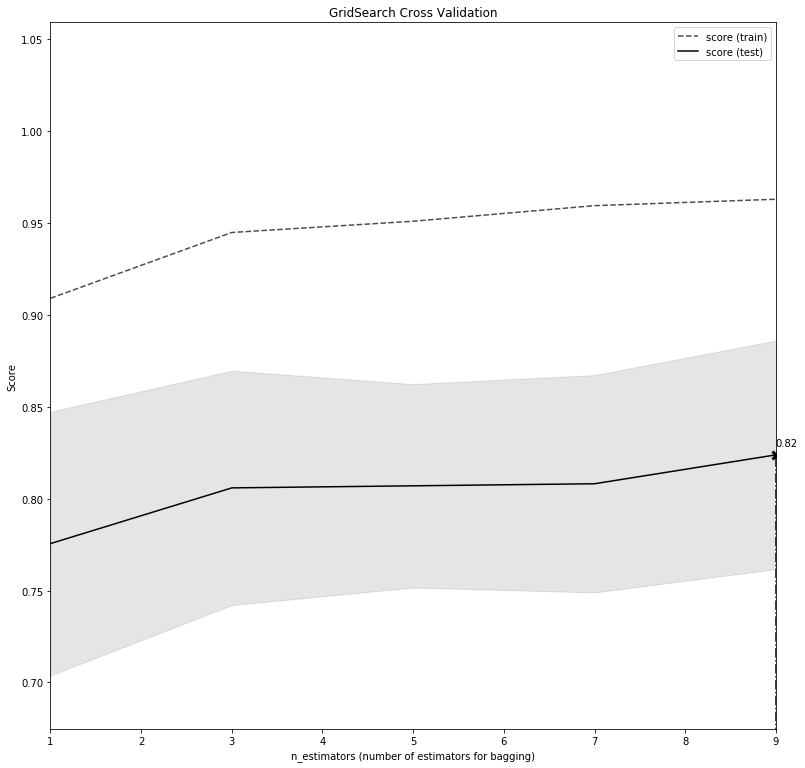

In [23]:
gridsearch_vis(clf, x_label='n_estimators', x_range=params['n_estimators'])

### Bagging for Random Forest

In [24]:
from sklearn.ensemble import BaggingClassifier
params = {"base_estimator__criterion" : ["gini", "entropy"],
          "base_estimator__n_estimators" : [10, 20, 30, 40, 50,100,150,200],
          "n_estimators" : range(1,11,2),
          "bootstrap_features":  [True, False]}
rf = RandomForestClassifier(random_state=117)
bagging_rf = BaggingClassifier(rf, random_state=117)
clf = GridSearchCV(bagging_rf, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_Bagging_RandomForest.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_Bagging_RandomForest.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 493 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 743 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1093 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1543 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.1min finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params {'base_estimator__criterion': 'gini', 'base_estimator__n_estimators': 30, 'bootstrap_features': False, 'n_estimators': 5}
Best training score: 0.936027109656623
Best Cross Valiadtion score: 0.8316498316498316


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.72248


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

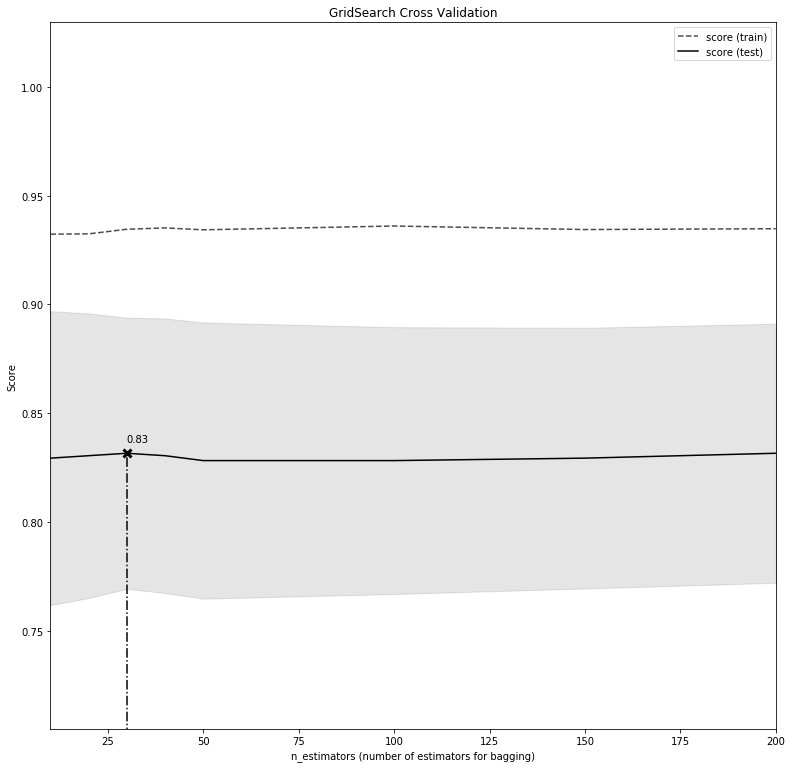

In [25]:
gridsearch_vis(clf, x_label='base_estimator__n_estimators', x_range=params['base_estimator__n_estimators'])

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

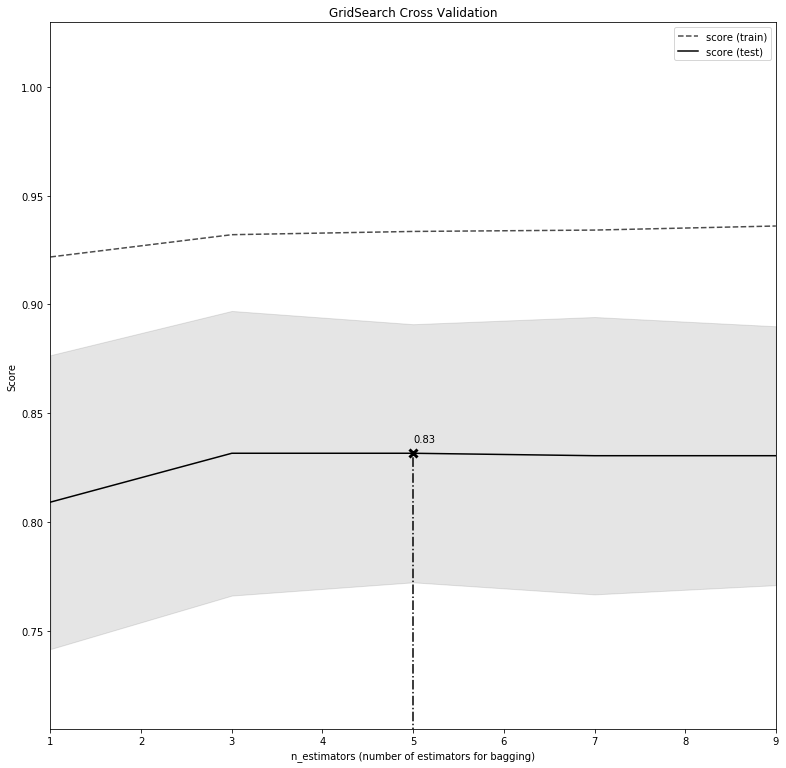

In [26]:
gridsearch_vis(clf, x_label='n_estimators', x_range=params['n_estimators'])

### AdaBoost for Decision Tree

In [29]:
from sklearn.ensemble import AdaBoostClassifier
params = {"base_estimator__criterion" : ["gini", "entropy"],
          "base_estimator__splitter" :   ["best", "random"],
          "algorithm" : ["SAMME","SAMME.R"],
          "n_estimators" :[1,2],
          "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
dtree = DecisionTreeClassifier(random_state=117)
adaboost_dtree = AdaBoostClassifier(dtree, random_state=117)
clf = GridSearchCV(adaboost_dtree, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_AdaBoost_Dtree.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_AdaBoost_Dtree.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    0.6s


Best params {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 0.1, 'n_estimators': 2}
Best training score: 0.9779275212667644
Best Cross Valiadtion score: 0.8013468013468014


[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:    1.3s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.72727


In [31]:
from sklearn.ensemble import AdaBoostClassifier
params = {"base_estimator__criterion" : ["gini", "entropy"],
          "base_estimator__n_estimators" : [10, 20, 30, 40, 50,100,150,200],
          "algorithm" : ["SAMME","SAMME.R"],
          "n_estimators" :[1,2],
          "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
rf = RandomForestClassifier(random_state=117)
adaboost_rf = AdaBoostClassifier(rf, random_state=117)
clf = GridSearchCV(adaboost_rf, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_Random_Forest.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_Random_Forest.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 448 candidates, totalling 4480 fits


[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1955 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2751 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3553 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4480 out of 4480 | elapsed:  3.5min finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_trai

Best params {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'entropy', 'base_estimator__n_estimators': 20, 'learning_rate': 0.3, 'n_estimators': 2}
Best training score: 0.9779275212667644
Best Cross Valiadtion score: 0.8249158249158249
Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.74641


### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': [2,4,6,8,10],
          'weights': ['uniform', 'distance'],
          'algorithm': ['ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10,20,30,40],
          'p': [2,3,4]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_KNN.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_KNN.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 2216 tasks      | elapsed:    9.3s


Best params {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Best training score: 0.9779275212667644
Best Cross Valiadtion score: 0.7362514029180696


[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:   21.2s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.63636


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

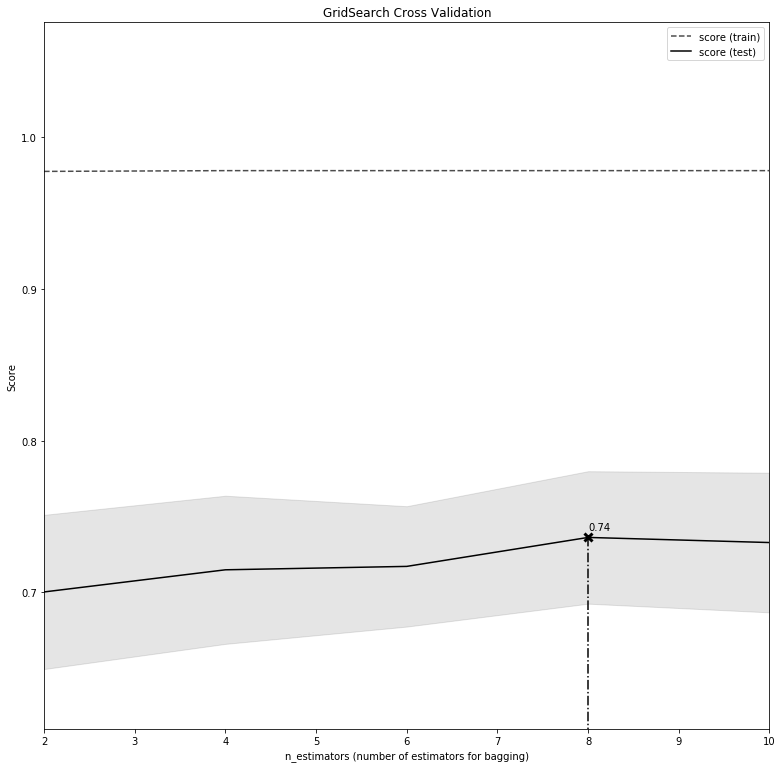

In [33]:
gridsearch_vis(clf, x_label='n_neighbors', x_range=params['n_neighbors'])

### Gradient Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
params = {'loss' : ["deviance"],
          'n_estimators' : [100,200,300],
          'learning_rate': [0.1, 0.05, 0.01],
          'max_depth': [4, 8],
          'min_samples_leaf': [100,150],
          'max_features': [0.3, 0.1] 
          }
gb = GradientBoostingClassifier(random_state=117)
clf = GridSearchCV(gb, params, cv=10, n_jobs=-1, verbose=1)
clf.fit(train_data, train_label)
print('Best params', clf.best_params_)
print('Best training score:', max(clf.cv_results_['mean_train_score']))
print('Best Cross Valiadtion score:', clf.best_score_)
print(clf.best_estimator_.feature_importances_)
test_label = clf.predict(test_data)
submission = []
for i, j in enumerate(test_label):
    submission.append({'PassengerId': i+892, 'Survived': int(j)})
pd.DataFrame.from_dict(submission).to_csv('../data/submission_GradientBoosting.csv',index=False)
!kaggle competitions submit -c titanic -f ../data/submission_GradientBoosting.csv -m 'trail'
print()
print('submission score: ', end='')
!kaggle competitions submissions -c titanic | head -3 | tail -1 | awk '{print $6}'

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   14.2s finished
/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 0.3, 'min_samples_leaf': 100, 'n_estimators': 300}
Best training score: 0.8658191788079858
Best Cross Valiadtion score: 0.8215488215488216
[0.09929981 0.12283435 0.2601857  0.04079553 0.04637783 0.40940002
 0.02110676]


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Successfully submitted to Titanic: Machine Learning from Disaster
submission score: 0.76555


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, pl

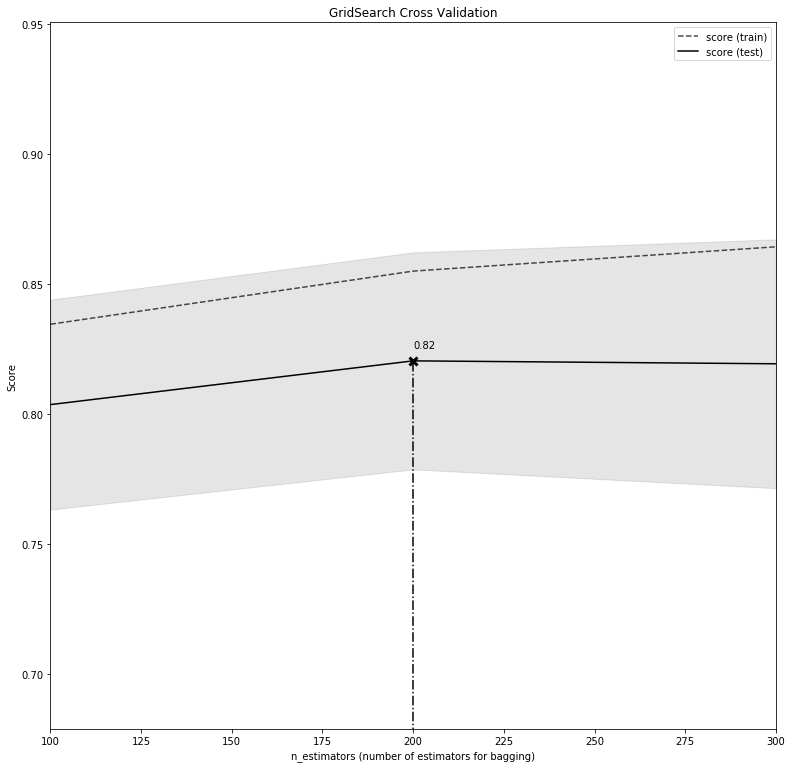

In [30]:
gridsearch_vis(clf, x_label='n_estimators', x_range=params['n_estimators'])